<a href="https://colab.research.google.com/github/sujinee01/Capstone/blob/main/SOC_ESTIMATION_TCN_%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# 모든 엑셀 파일 순서대로 불러오기
import os
import pandas as pd

def load_excel_files(base_path):
    # 데이터를 저장할 리스트
    all_data = []

    # 상위 폴더의 하위 폴더들을 순회
    for folder in sorted(os.listdir(base_path)): # sorted 함수 : 온도 순서대로
        # -10도 폴더 제외
        if folder == "-10도":
            continue

        folder_path = os.path.join(base_path, folder)

        # 폴더 내의 엑셀 파일들을 순회
        if os.path.isdir(folder_path):  # 폴더인지 확인
            excel_files = sorted(os.listdir(folder_path)) # sorted 함수 : cycle 순서대로
            for file in excel_files:
                file_path = os.path.join(folder_path, file)

                # 파일 확장자가 .xlsx인지 확인 후 불러오기
                if file.endswith('.xlsx'):
                    data = pd.read_excel(file_path)
                    all_data.append(data)

    return all_data

base_path = '/content/drive/MyDrive/LiFePO4 Dynamic Profile Files'
data_list = load_excel_files(base_path)

# 데이터 리스트 출력
for idx, data in enumerate(data_list):
    print(f"DataFrame {idx + 1}:")
    print(data.head())
    print()
print("Total number of data:", len(data_list))

DataFrame 1:
   Test_Time(s)  Step_Time(s)  Step_Index  Current(A)  Voltage(V)  \
0   6056.188227    120.006818           7    0.000000    3.537679   
1   6057.190725      1.001931           8    0.000191    3.537064   
2   6058.196769      2.007975           8    0.000191    3.536756   
3   6059.204793      3.015999           8    0.000191    3.536756   
4   6060.209850      4.021056           8    0.000191    3.536140   

   Temperature (C)_1     SOC(t) Unnamed: 7                 Unnamed: 8  \
0           0.159476  80.000000     SOC(0)  가용 전체 용량 =-3374.966641/80   
1           0.007843  80.000000        NaN                 -42.187083   
2           0.114642  80.000005        NaN                        NaN   
3          -0.023220  80.000009        NaN                        NaN   
4           0.007843  80.000014        NaN                        NaN   

   Unnamed: 9 Unnamed: 10  
0         NaN         NaN  
1         NaN         NaN  
2         NaN         NaN  
3         NaN        

In [ ]:
pip install scipy

In [ ]:
from scipy.signal import butter, filtfilt, medfilt
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.signal import savgol_filter

In [ ]:
# 각 데이터프레임 전처리 및 특성 추가

for data in data_list:
    # 불필요한 열 제거
    data.drop(columns=['Step_Time(s)','Step_Index','Unnamed: 7','Unnamed: 8','Unnamed: 9','Unnamed: 10'], inplace=True)

    # 결측치가 있는 행 제거
    data.dropna(inplace=True)

    # Driving_Cycle 특성 추가

    # Savitzky-Golay 필터
    data['SG_Current(A)'] = savgol_filter(data['Current(A)'], window_length=19, polyorder=2)  #21,2 window length 클수록, poly order 작을수록 부드러움 #windowlength=51->35%
    # LOWESS 스무딩
    data['SG_LOWESS_Current(A)'] = lowess(data['SG_Current(A)'], data['Test_Time(s)'], frac=0.01)[:, 1]

    # DataFrame의 상위 5개 행을 출력
    print(data.head())
    print('===================================================================')

   Test_Time(s)  Current(A)  Voltage(V)  Temperature (C)_1     SOC(t)  \
0   6056.188227    0.000000    3.537679           0.159476  80.000000   
1   6057.190725    0.000191    3.537064           0.007843  80.000000   
2   6058.196769    0.000191    3.536756           0.114642  80.000005   
3   6059.204793    0.000191    3.536756          -0.023220  80.000009   
4   6060.209850    0.000191    3.536140           0.007843  80.000014   

   SG_Current(A)  SG_LOWESS_Current(A)  
0      -0.075127              0.063376  
1      -0.038214              0.045794  
2      -0.007330              0.028203  
3       0.017523              0.010639  
4       0.036346             -0.006806  
   Test_Time(s)  Current(A)  Voltage(V)  Temperature (C)_1     SOC(t)  \
0   6585.405365    0.000000    3.536439           0.310773  80.000000   
1   6586.406185   -0.000271    3.536747           0.310773  80.000000   
2   6587.406312   -0.000451    3.536131           0.190023  79.999993   
3   6588.407249   -0.00

In [ ]:
# 특성과 타겟을 저장할 리스트 초기화
features_list = []
targets_list = []

# 데이터 리스트 순회
for df in data_list:
    features = df[['SG_LOWESS_Current(A)', 'Voltage(V)', 'Temperature (C)_1']]
    targets = df['SOC(t)']
    features_list.append(features)
    targets_list.append(targets)

# 결과 확인
print("Features List:")
for idx, features in enumerate(features_list):
    print(f"Features {idx + 1} - Shape: {features.shape}")
    print(features.head())  # 각 특성 DataFrame의 상위 데이터를 출력

print("\nTargets List:")
for targets in targets_list:
    print(targets.head())  # 각 타겟 Series의 상위 데이터를 출력

Features List:
Features 1 - Shape: (6739, 3)
   SG_LOWESS_Current(A)  Voltage(V)  Temperature (C)_1
0              0.063376    3.537679           0.159476
1              0.045794    3.537064           0.007843
2              0.028203    3.536756           0.114642
3              0.010639    3.536756          -0.023220
4             -0.006806    3.536140           0.007843
Features 2 - Shape: (6383, 3)
   SG_LOWESS_Current(A)  Voltage(V)  Temperature (C)_1
0              0.075121    3.536439           0.310773
1              0.056889    3.536747           0.310773
2              0.038711    3.536131           0.190023
3              0.020569    3.536131           0.083193
4              0.002427    3.535823           0.386634
Features 3 - Shape: (7020, 3)
   SG_LOWESS_Current(A)  Voltage(V)  Temperature (C)_1
0             -0.001023    3.538295          -0.123602
1             -0.018010    3.537987          -0.047491
2             -0.034812    3.537679           0.090752
3             -

In [ ]:
# train/validation/test split

# train/validation/test split

# features_list와 targets_list에서 짝수 인덱스 요소 선택(모든 온도와 driving_cycle에 대해 학습)
X_train_val = features_list[::2] # 학습+검증 : 0도~50도(21개 파일)
y_train_val = targets_list[::2]

X_train=X_train_val[:16:] # 학습 : 0도, 10도, 20도, 25도, 30도(16개 파일)
y_train=y_train_val[:16:]

X_val=X_train_val[16::] # 검증 : 40도, 50도(5개 파일)
y_val=y_train_val[16::]

# features_list와 targets_list에서 홀수 인덱스 요소 선택
X_test= features_list[1::2] # 테스트 : 0도~50도(21개 파일)
y_test= targets_list[1::2]

In [ ]:
# 결과 출력
print('Train_set')
print('Train_set data count:', len(X_train))
print(X_train)
print(y_train)

print('Validation_set')
print('Validation_set data count:', len(X_val))
print(X_val)
print(y_val)

print('Test_set')
print('Test_set data count:', len(X_test))
print(X_test)
print(y_test)

Train_set
Train_set data count: 16
[      SG_LOWESS_Current(A)  Voltage(V)  Temperature (C)_1
0                 0.063376    3.537679           0.159476
1                 0.045794    3.537064           0.007843
2                 0.028203    3.536756           0.114642
3                 0.010639    3.536756          -0.023220
4                -0.006806    3.536140           0.007843
...                    ...         ...                ...
6734             -0.715410    2.640821           1.256174
6735             -0.729885    2.638666           1.225199
6736             -0.744356    2.636512           1.256174
6737             -0.758833    2.634357           1.225199
6738             -0.770731    1.981565           1.256174

[6739 rows x 3 columns],       SG_LOWESS_Current(A)  Voltage(V)  Temperature (C)_1
0                -0.001023    3.538295          -0.123602
1                -0.018010    3.537987          -0.047491
2                -0.034812    3.537679           0.090752
3         

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 학습 데이터를 이용하여 스케일러를 학습
scaler = MinMaxScaler()
for features in X_train:
    scaler.partial_fit(features)

# 학습된 스케일러를 이용하여 각 데이터셋을 정규화
X_train_scaled = [scaler.transform(features) for features in X_train]
X_val_scaled = [scaler.transform(features) for features in X_val]
X_test_scaled = [scaler.transform(features) for features in X_test]

In [ ]:
print('Train_set')
print(X_train_scaled)
print(len(X_train_scaled))
print(len(X_test_scaled))

Train_set
[array([[0.8836669 , 0.89358778, 0.01574081],
       [0.87718247, 0.89324394, 0.01223803],
       [0.87069505, 0.89307201, 0.01470513],
       ...,
       [0.58577688, 0.39023549, 0.04107501],
       [0.58043788, 0.38903217, 0.04035947],
       [0.57605013, 0.02441121, 0.04107501]]), array([[0.85991664, 0.89393163, 0.00920159],
       [0.85365192, 0.8937597 , 0.01095978],
       [0.8474551 , 0.89358778, 0.01415326],
       ...,
       [0.71959561, 0.15523464, 0.06051766],
       [0.7136767 , 0.06738872, 0.05876568],
       [0.71093112, 0.01340896, 0.05979694]]), array([[0.67339304, 0.8937597 , 0.00961157],
       [0.67671962, 0.89358778, 0.01319834],
       [0.68018235, 0.89341586, 0.01104803],
       ...,
       [0.3842999 , 0.08612695, 0.03909063],
       [0.37326851, 0.30015472, 0.03805671],
       [0.36737455, 0.02320788, 0.03733889]]), array([[0.87667875, 0.8990889 , 0.24592591],
       [0.87048939, 0.89754173, 0.24346248],
       [0.86432483, 0.89754173, 0.24346248],
  

In [ ]:
import numpy as np

# 가장 긴 시퀀스 길이 계산
max_length = max(
    max(df.shape[0] for df in X_train_scaled + X_val_scaled + X_test_scaled),
    max(len(y) for y in y_train + y_val + y_test) # X_df1과 y_df1의 길이는 같으므로 생략 가능(결측치 제거했기 때문)
)

# 패딩 적용
X_train_padded = np.array([np.pad(df, ((0, max_length - df.shape[0]), (0, 0)), 'constant', constant_values=0) for df in X_train_scaled])
X_val_padded = np.array([np.pad(df, ((0, max_length - df.shape[0]), (0, 0)), 'constant', constant_values=0) for df in X_val_scaled])
X_test_padded = np.array([np.pad(df, ((0, max_length - df.shape[0]), (0, 0)), 'constant', constant_values=0) for df in X_test_scaled])

y_train_padded = np.array([np.pad(series, (0, max_length - len(series)), 'constant', constant_values=0) for series in y_train])
y_val_padded = np.array([np.pad(series, (0, max_length - len(series)), 'constant', constant_values=0) for series in y_val])
y_test_padded = np.array([np.pad(series, (0, max_length - len(series)), 'constant', constant_values=0) for series in y_test])

# 패딩된 결과 출력 (예시)
print("Padded X_train:")
print(X_train_padded)
print("Padded y_train:")
print(y_train_padded)

Padded X_train:
[[[0.8836669  0.89358778 0.01574081]
  [0.87718247 0.89324394 0.01223803]
  [0.87069505 0.89307201 0.01470513]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.85991664 0.89393163 0.00920159]
  [0.85365192 0.8937597  0.01095978]
  [0.8474551  0.89358778 0.01415326]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.67339304 0.8937597  0.00961157]
  [0.67671962 0.89358778 0.01319834]
  [0.68018235 0.89341586 0.01104803]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.85385305 0.90493387 0.75657259]
  [0.84788442 0.90424618 0.75727535]
  [0.84210233 0.90424618 0.75485511]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.68815121 0.90355849 0.75259233]
  [0.69103298 0.90441

In [ ]:
!pip install keras-tcn

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Define the Residual Block
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate):
        super(ResidualBlock, self).__init__()
        self.dropout1 = layers.Dropout(0.2)
        self.conv1 = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')
        self.relu1 = layers.ReLU()
        self.weight_norm1 = layers.BatchNormalization()

        self.dropout2 = layers.Dropout(0.2)
        self.conv2 = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')
        self.relu2 = layers.ReLU()
        self.weight_norm2 = layers.BatchNormalization()

        self.conv1x1 = layers.Conv1D(filters, 1)
        self.identity_map = layers.Conv1D(filters, 1)  # To match the shape for addition

    def call(self, inputs, training=None):
        x = self.dropout1(inputs, training=training)
        x = self.conv1(x)
        x = self.weight_norm1(x, training=training)
        x = self.relu1(x)

        x = self.dropout2(x, training=training)
        x = self.conv2(x)
        x = self.weight_norm2(x, training=training)
        x = self.relu2(x)

        x = self.conv1x1(x)

        # Ensure the input and output shapes match
        identity = self.identity_map(inputs)

        return layers.add([identity, x])

# Define the TCN model
def build_tcn_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    # Number of residual blocks
    for dilation_rate in [1, 2, 4, 8, 16, 32]:  # Example dilation rates
        x = ResidualBlock(filters=64, kernel_size=3, dilation_rate=dilation_rate)(x)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation='linear')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# 모델 입력 형상과 클래스 수를 정의
input_shape = (X_train_padded.shape[1], X_train_padded.shape[2])
num_classes = y_train_padded.shape[1]

# 모델 빌드 및 컴파일
model = build_tcn_model(input_shape, num_classes)
model.compile(optimizer=optimizers.Adam(), loss='mean_squared_error', metrics=['mse'])

# 모델 요약 출력
model.summary()

# 모델 훈련
history = model.fit(X_train_padded, y_train_padded, epochs=100, batch_size=4, validation_data=(X_val_padded, y_val_padded))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7806, 3)]         0         
                                                                 
 residual_block (ResidualBl  (None, 7806, 64)          17920     
 ock)                                                            
                                                                 
 residual_block_1 (Residual  (None, 7806, 64)          33536     
 Block)                                                          
                                                                 
 residual_block_2 (Residual  (None, 7806, 64)          33536     
 Block)                                                          
                                                                 
 residual_block_3 (Residual  (None, 7806, 64)          33536     
 Block)                                                      

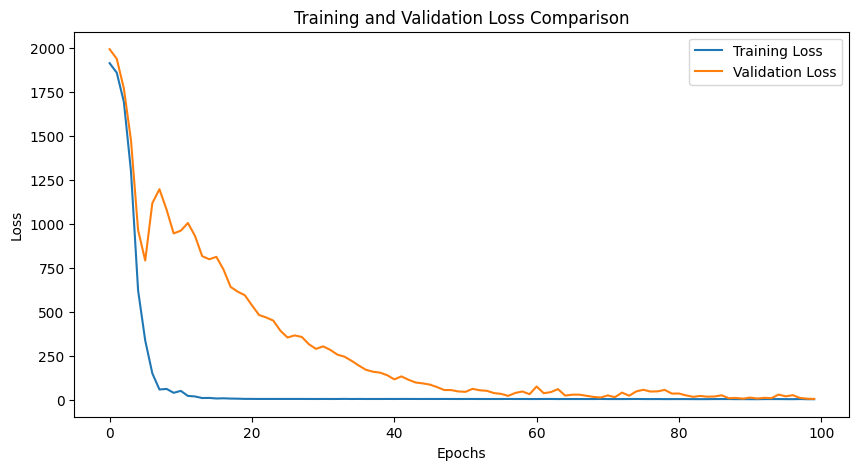

In [ ]:
import matplotlib.pyplot as plt

# 학습 손실과 검증 손실 값 가져오기
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 손실 값 비교 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.show()


In [ ]:
import numpy as np

# 패딩된 학습 데이터와 검증 데이터를 합치기
X_combined = np.concatenate((X_train_padded, X_val_padded), axis=0)
y_combined = np.concatenate((y_train_padded, y_val_padded), axis=0)

# 합쳐진 데이터의 크기 출력
print("Combined X shape:", X_combined.shape)
print("Combined y shape:", y_combined.shape)


Combined X shape: (21, 7806, 3)
Combined y shape: (21, 7806)


In [ ]:
# 모델 입력 형상과 클래스 수를 정의
input_shape = (X_combined.shape[1], X_combined.shape[2])
num_classes = y_combined.shape[1]

# 모델 빌드 및 컴파일
model = build_tcn_model(input_shape, num_classes)
model.compile(optimizer=optimizers.Adam(), loss='mean_squared_error', metrics=['mse'])

# 모델 요약 출력
model.summary()

# 모델 훈련
history = model.fit(X_combined, y_combined, epochs=100, batch_size=4)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7806, 3)]         0         
                                                                 
 residual_block_6 (Residual  (None, 7806, 64)          17920     
 Block)                                                          
                                                                 
 residual_block_7 (Residual  (None, 7806, 64)          33536     
 Block)                                                          
                                                                 
 residual_block_8 (Residual  (None, 7806, 64)          33536     
 Block)                                                          
                                                                 
 residual_block_9 (Residual  (None, 7806, 64)          33536     
 Block)                                                    

In [ ]:
# 모델 예측
y_pred = model.predict(X_test_padded)

# 각 표본에 대한 손실값 계산
loss_fn = tf.keras.losses.MeanSquaredError()
losses = []
rmses = []

for true, pred in zip(y_test_padded, y_pred):
    loss = loss_fn(true, pred).numpy()
    rmse = np.sqrt(loss)
    losses.append(loss)
    rmses.append(rmse)

# 손실값 및 RMSE 출력
for idx, (loss, rmse) in enumerate(zip(losses, rmses)):
    print(f'Sample {idx}: Loss = {loss}, RMSE = {rmse}')

1/1 [==============================] - 2s 2s/step
Sample 0: Loss = 20.000776290893555, RMSE = 4.472222805023193
Sample 1: Loss = 43.75309753417969, RMSE = 6.614612579345703
Sample 2: Loss = 20.623369216918945, RMSE = 4.541296005249023
Sample 3: Loss = 40.01321792602539, RMSE = 6.3256001472473145
Sample 4: Loss = 51.579437255859375, RMSE = 7.181882381439209
Sample 5: Loss = 57.10677719116211, RMSE = 7.5569024085998535
Sample 6: Loss = 15.38839054107666, RMSE = 3.9228038787841797
Sample 7: Loss = 26.97386932373047, RMSE = 5.193637371063232
Sample 8: Loss = 19.810789108276367, RMSE = 4.450931072235107
Sample 9: Loss = 2.848095655441284, RMSE = 1.6876301765441895
Sample 10: Loss = 7.519001007080078, RMSE = 2.742079734802246
Sample 11: Loss = 5.325146198272705, RMSE = 2.3076279163360596
Sample 12: Loss = 1.8593826293945312, RMSE = 1.3635917901992798
Sample 13: Loss = 5.066676616668701, RMSE = 2.2509279251098633
Sample 14: Loss = 4.759097099304199, RMSE = 2.181535482406616
Sample 15: Loss = 

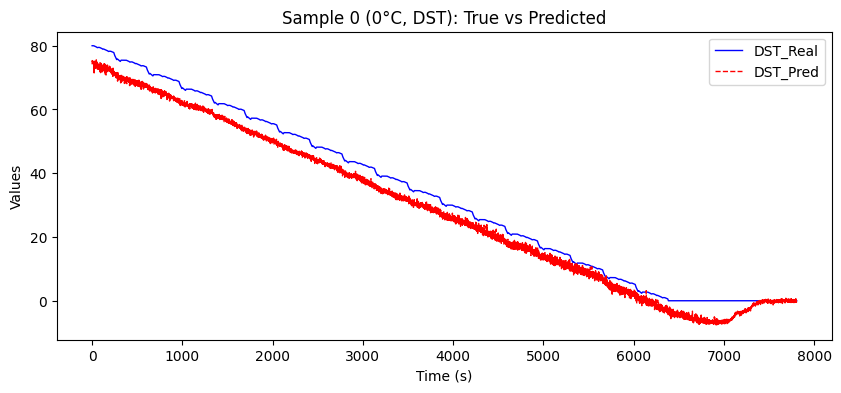

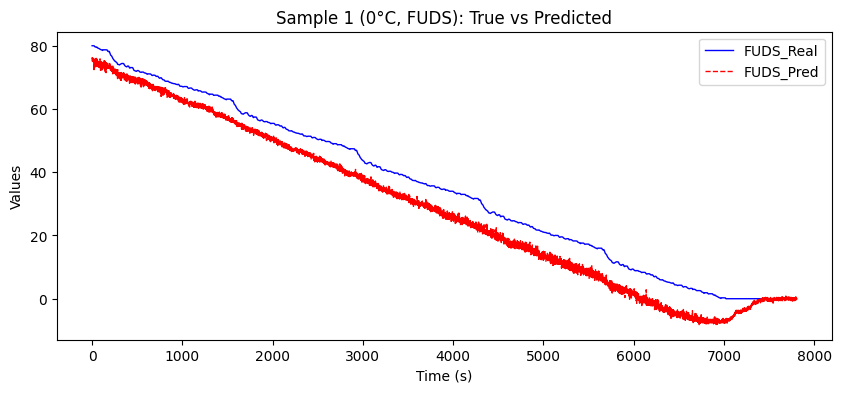

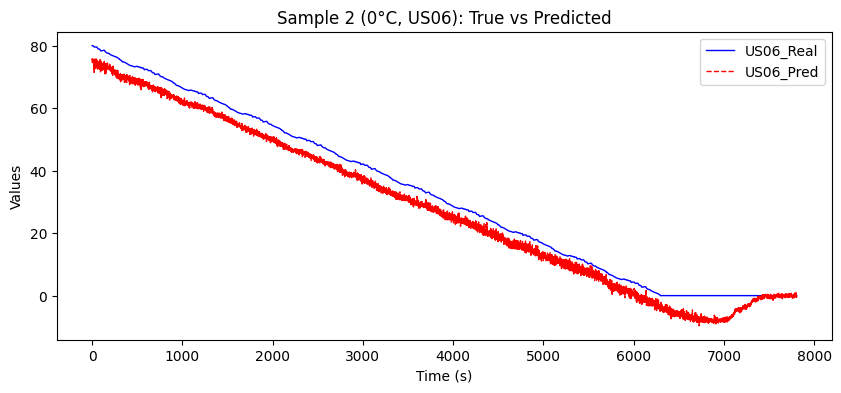

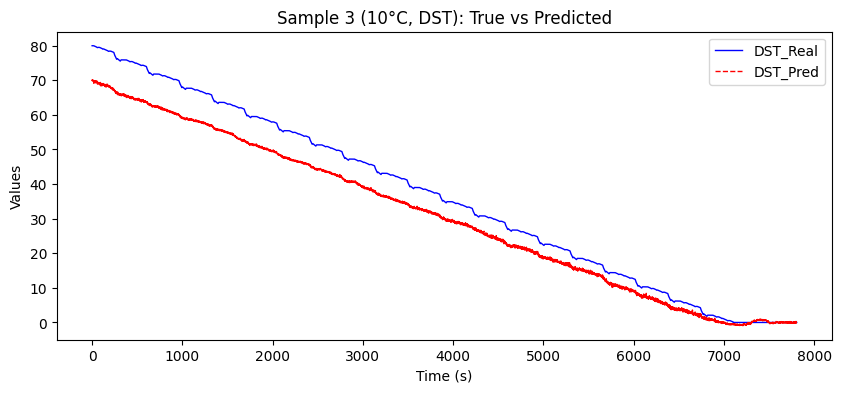

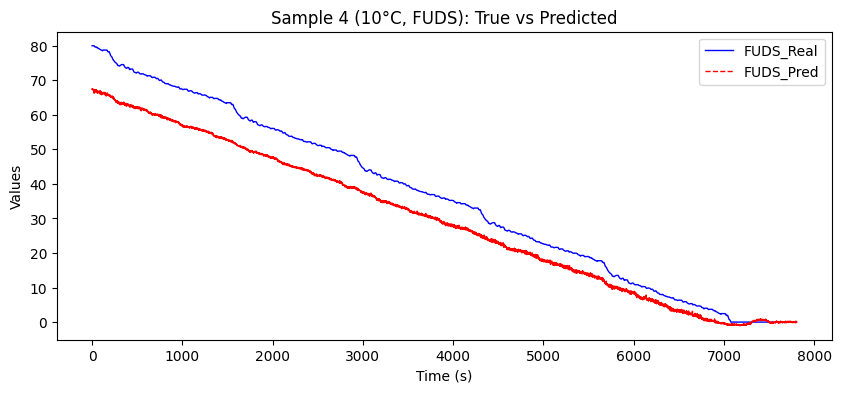

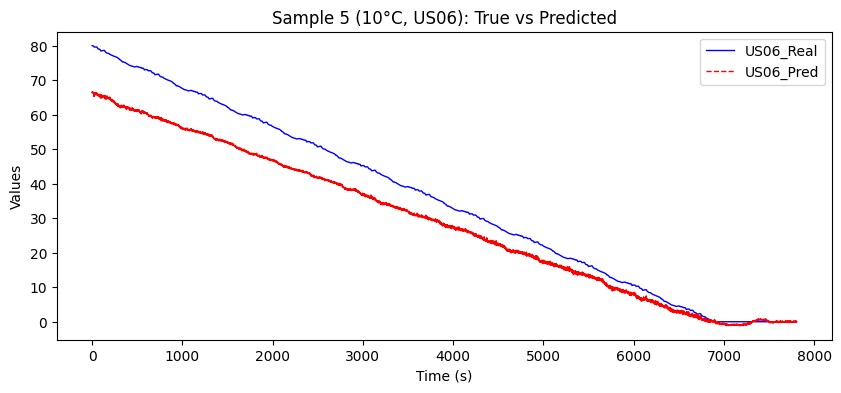

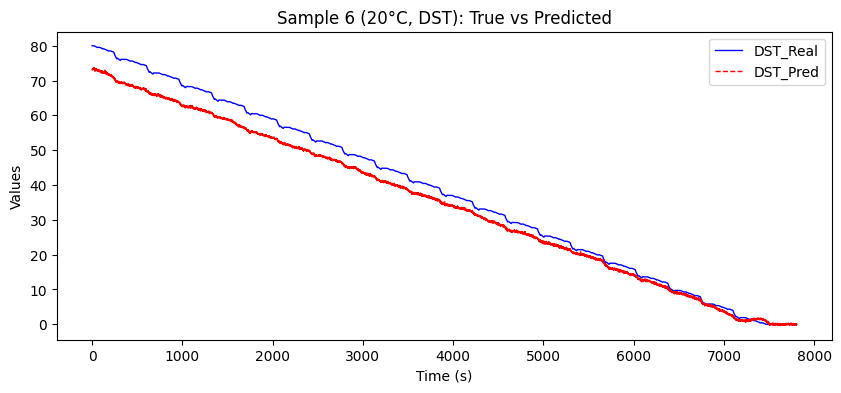

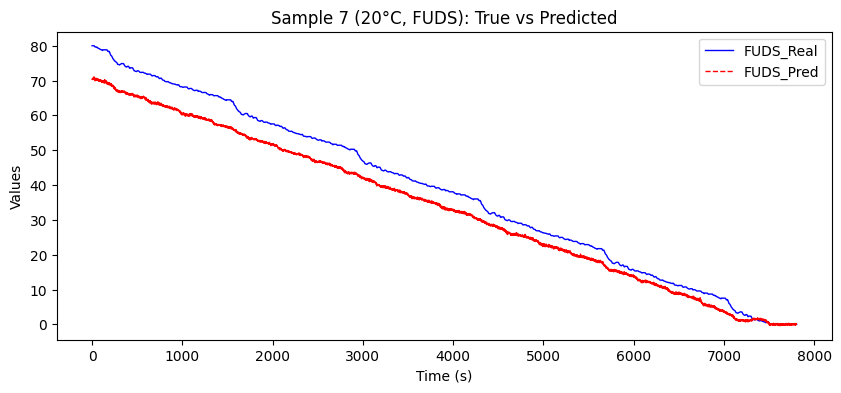

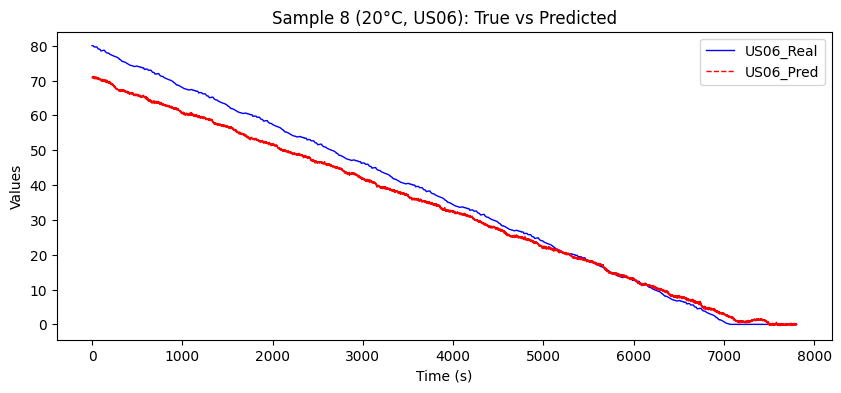

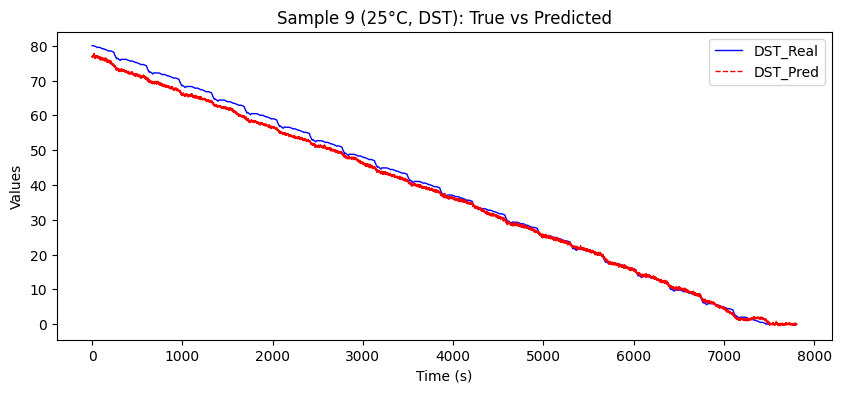

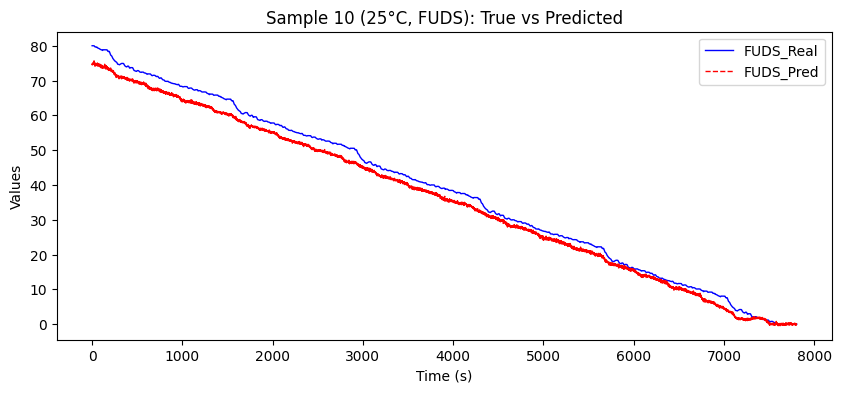

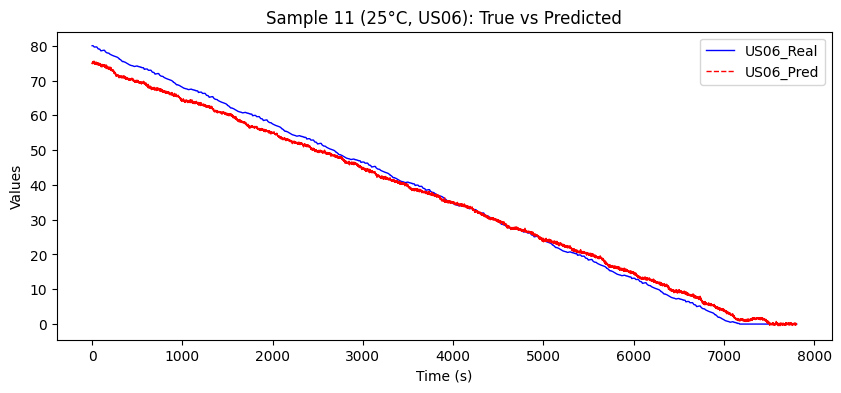

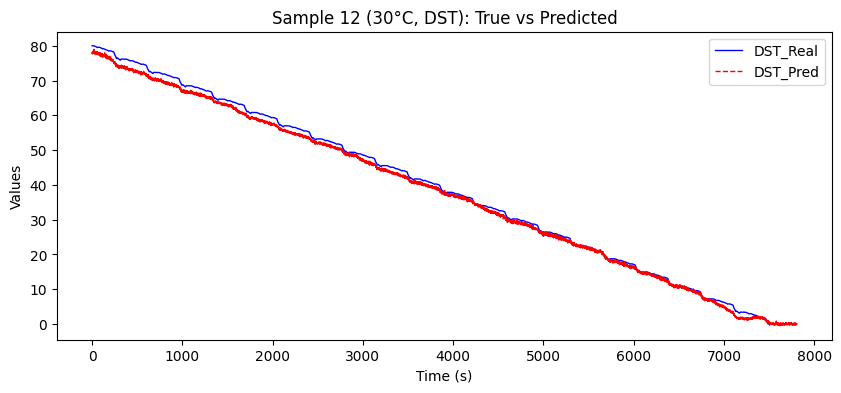

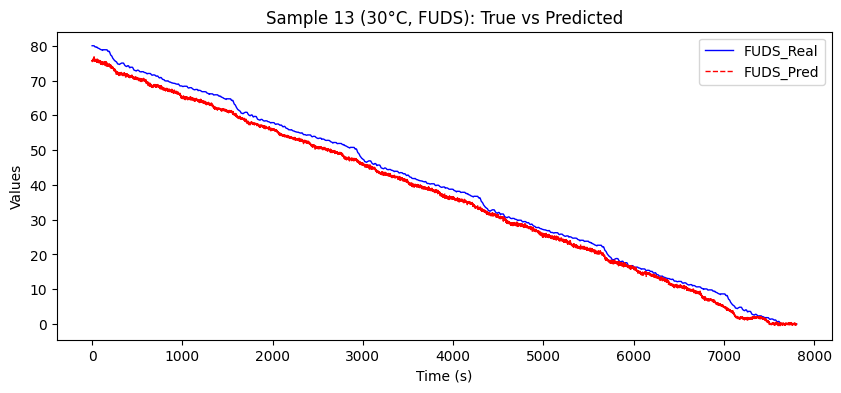

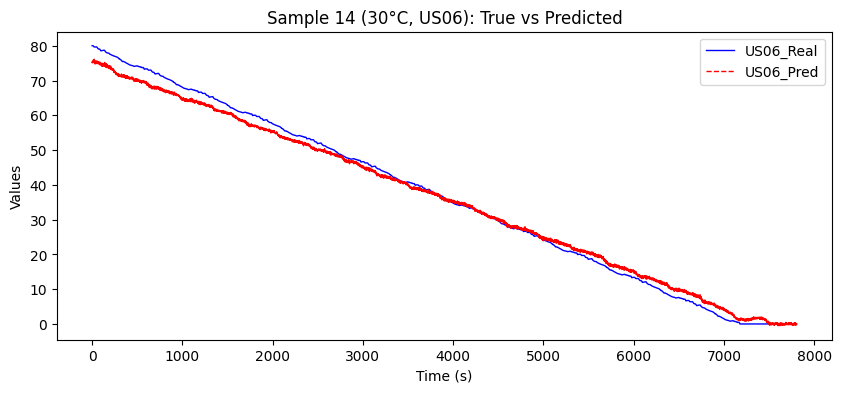

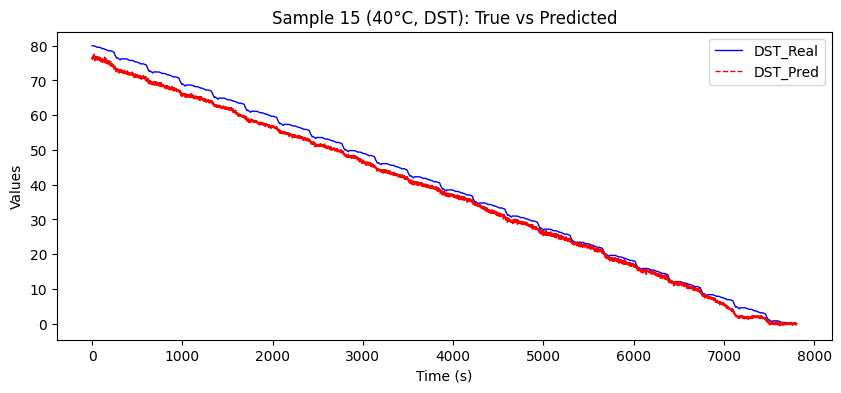

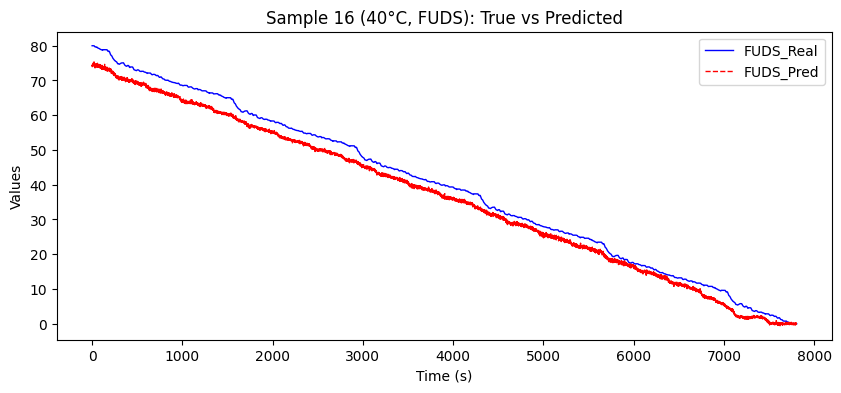

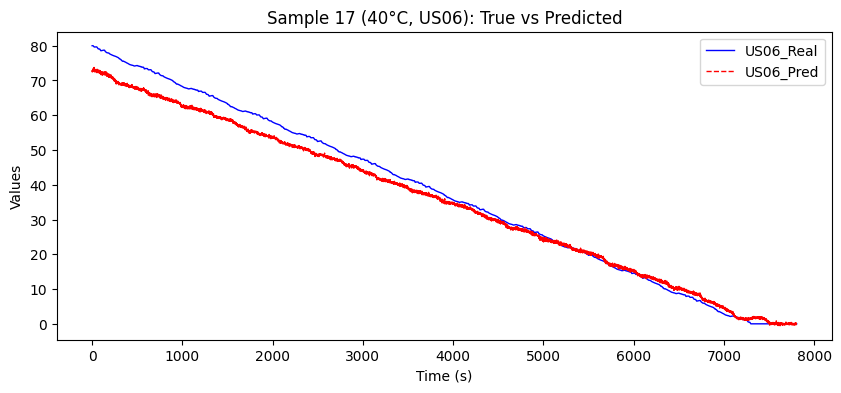

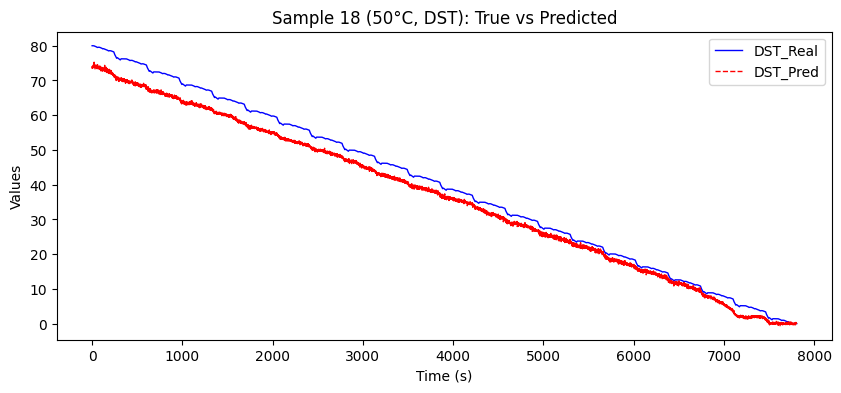

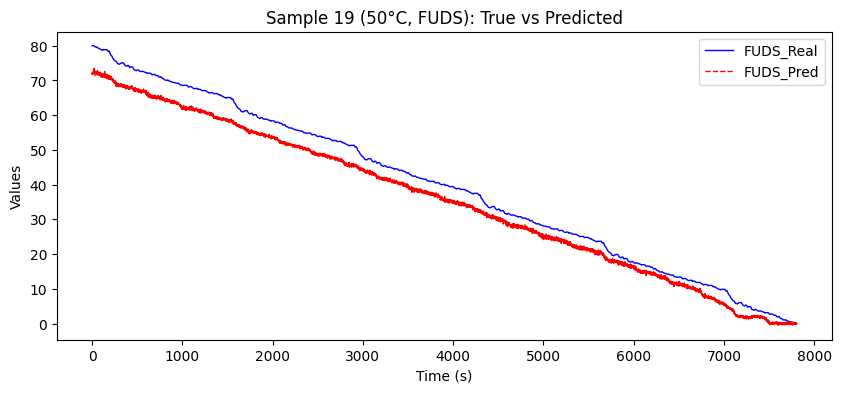

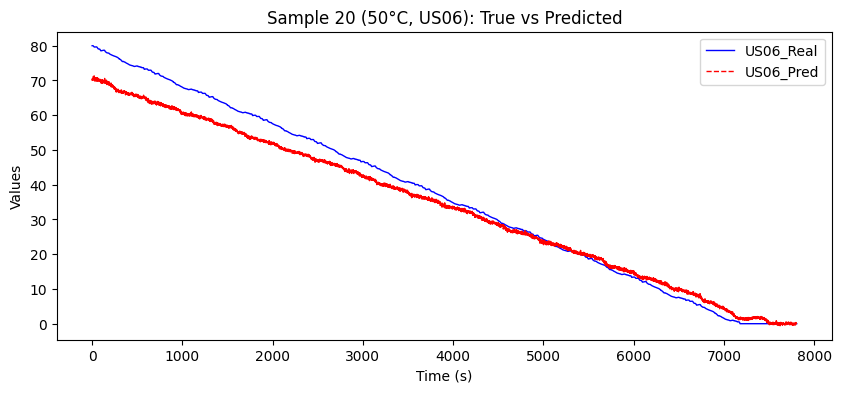

In [ ]:
# 온도와 조건 레이블 정의
temperatures = [0, 10, 20, 25, 30, 40, 50]
conditions = ['DST', 'FUDS', 'US06']
sample_info = [(temp, cond) for temp in temperatures for cond in conditions]

# 각 표본에 대해 y_test와 y_pred를 비교하는 그래프 생성
num_samples = len(y_test_padded)
for idx in range(num_samples):
    temp, cond = sample_info[idx]
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_padded[idx], label=f'{cond}_Real', color='blue', linewidth=1.0)
    plt.plot(y_pred[idx], label=f'{cond}_Pred', color='red', linestyle='--', linewidth=1.0)
    plt.title(f'Sample {idx} ({temp}°C, {cond}): True vs Predicted')
    plt.xlabel('Time (s)')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

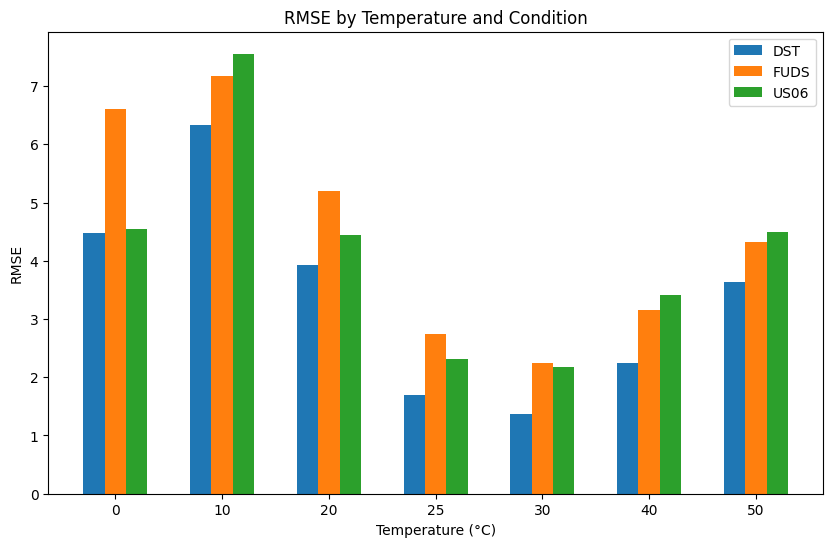

In [ ]:
# 그래프 그리기
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = np.arange(len(temperatures))

for i, condition in enumerate(conditions):
    rmse_subset = rmses[i::3]
    ax.bar(index + i * bar_width, rmse_subset, bar_width, label=condition)

ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Temperature and Condition')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(temperatures)
ax.legend()

plt.show()